In [8]:
import os
import pandas as pd
import numpy as np
import datetime
from dateutil.parser import parse
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("Order-2022-09-26.csv")
data.info()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26436\1243554808.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Order-2022-09-26.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264341 entries, 0 to 264340
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_items           264341 non-null  object 
 1   shipping_postal_code  263979 non-null  object 
 2   shipping_date         264256 non-null  object 
 3   discounts             264341 non-null  object 
 4   subscription_id       121404 non-null  float64
 5   user_id               264328 non-null  float64
 6   id                    264341 non-null  int64  
 7   number                264341 non-null  object 
 8   currency              264341 non-null  object 
 9   total_incl_tax        264341 non-null  float64
 10  total_excl_tax        264341 non-null  float64
 11  shipping_incl_tax     264341 non-null  float64
 12  shipping_method       264341 non-null  object 
 13  shipping_code         264341 non-null  object 
 14  status                264341 non-null  object 
 15  

In [5]:
df = data.loc[:,["shipping_date", "date_placed"]]
tp_ship = []
tp_place = []
f = data["shipping_date"].isna().values
for i in tqdm(range(264340)):
    p1 = parse(data["date_placed"][i]).replace(tzinfo=None)
    tp_place.append(p1)
    if f[i]:
        tp_ship.append(p1)
    else:
        p2 = parse(data["shipping_date"][i], dayfirst =True)
        tp_ship.append(p2)

100%|████████████████████████████████████████████████████████████████████████| 264340/264340 [00:26<00:00, 9813.63it/s]


In [25]:
tp = []
for d1, d2 in zip(tp_ship, tp_place):
    tp.append((d1-d2).days)

In [33]:
for i in range(len(tp)):
    if tp[i]>  5000:
        print(i)
        

17212
20719
31504
37994
48666
48803
51893
52509
52588
56452
65515
85194
88007
91449
98634


In [35]:
print(data.loc[17212,"shipping_date"])
print(tp_place[17212])

29-12-2102
2016-08-28 09:31:20.368283


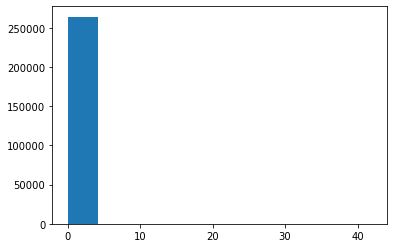

(array([ 7.,  2.,  0., 13.,  0.,  0.,  0.,  0.,  1.,  3.]),
 array([ 1. ,  5.1,  9.2, 13.3, 17.4, 21.5, 25.6, 29.7, 33.8, 37.9, 42. ]),
 <BarContainer object of 10 artists>)

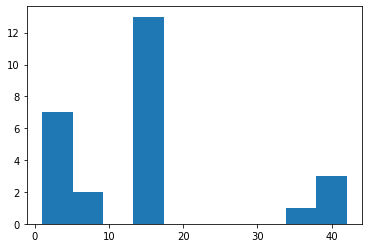

In [41]:
d_gap = [t for t in tp if t >= 0 and t < 100]
plt.hist(d_gap)
plt.show()
plt.hist([t for t in d_gap if t > 0])

In [131]:
lst = ["user_id","discounts","subscription_id","currency", "total_excl_tax", "status","date_placed"]
df = data.loc[:,lst]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264341 entries, 0 to 264340
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          264328 non-null  float64
 1   discounts        264341 non-null  object 
 2   subscription_id  121404 non-null  float64
 3   currency         264341 non-null  object 
 4   total_excl_tax   264341 non-null  float64
 5   status           264341 non-null  object 
 6   date_placed      264341 non-null  object 
dtypes: float64(3), object(4)
memory usage: 14.1+ MB


In [132]:
df = df.dropna(axis=0, how='any',subset="user_id", inplace=False)
print(df["user_id"].nunique()/len(df))

0.12141732998395932


In [133]:
lst = df["user_id"].unique()
cnt = dict(zip(lst, [0]*len(lst)))
for i in df["user_id"]:
    cnt[int(i)] += 1

,pruchase times
count,32094.000000
mean,8.236057
std,19.238991
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,610.000000


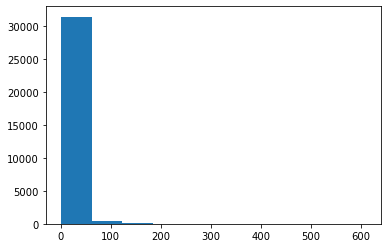

In [134]:
plt.hist(cnt.values())
tpd_cnt = pd.DataFrame(cnt.values(),columns = ["pruchase times"])
tpd_cnt.describe()

In [135]:
len(df)

264328

In [136]:
spent = dict(zip(lst, [0]*len(lst)))
for i in df.index:
    spent[int(df.loc[i,"user_id"])] += df.loc[i,"total_excl_tax"]

,total spent
count,32094.000000
mean,146.751246
std,322.584612
min,-2.000000
25%,28.000000
50%,53.280000
75%,126.000000
max,9794.000000


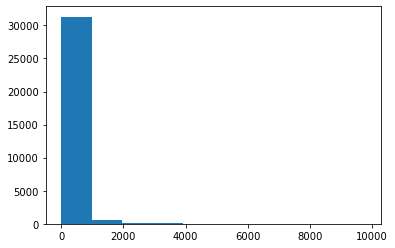

In [137]:
plt.hist(spent.values())
tpd_spent = pd.DataFrame(spent.values(),columns = ["total spent"])
tpd_spent.describe()

SpearmanrResult(correlation=0.6608444922093925, pvalue=0.0)


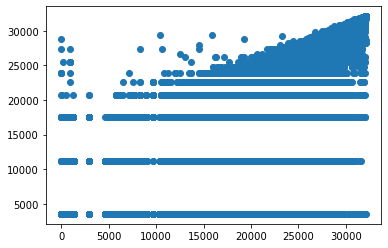

In [138]:
from scipy.stats import spearmanr
ct = tpd_cnt.rank()
sp = tpd_spent.rank()
print(spearmanr(sp.values, ct.values))
plt.scatter(sp.values,ct.values)

In [139]:
A = []
B = []
C = []
D = []
for i in lst:
    if cnt[i] > 6 and spent[i] < 126:
        A.append(i)
    elif cnt[i] > 6 and spent[i] > 126:
        B.append(i)
    elif cnt[i] < 6 and spent[i] < 126:
        C.append(i)
    else:
        D.append(i)        

In [140]:
print("A: " + str(len(A)))
print("B: " + str(len(B)))
print("C: " + str(len(C)))
print("D: " + str(len(D)))

A: 1320
B: 6305
C: 21881
D: 2588


In [180]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
X = np.array([list(cnt.values()), list(spent.values())]).T
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(32094, 2)

In [188]:
kmeans = KMeans(n_clusters=4).fit(X)
result = kmeans.labels_
M =[]
N =[]
P = []
Q = []
for i in range(len(result)):
    if result[i] == 0:
        M.append(i)
    elif result[i] == 1:
        N.append(i)
    elif result[i] == 2:
        P.append(i)
    else :
        Q.append(i)

In [190]:
print(len(M))
print(len(N))
print(len(P))
print(len(Q))
kmeans.cluster_centers_

2901
129
697
28367


array([[ 1.03883674,  1.06965249],
       [ 9.76010755,  9.08087805],
       [ 3.7138055 ,  3.84676377],
       [-0.24205868, -0.24539418]])

In [141]:
tpd = df["discounts"]
for i in df.index: 
    if df["discounts"][i] == "[]":
        df.loc[i,"discounts"] = 0
    else:
        df.loc[i,"discounts"] = 1   

0         0
1         0
2         0
3         0
4         0
         ..
264336    0
264337    1
264338    1
264339    0
264340    1
Name: discounts, Length: 264328, dtype: int32

In [143]:
df["discounts"] = df["discounts"].astype(int)

In [145]:
disc = dict(zip(lst, [0]*len(lst)))
for i in df.index:
    disc[int(df.loc[i,"user_id"])] += df.loc[i,"discounts"]

In [146]:
a_disc = b_disc = c_disc = d_disc = 0
for i in A:
    a_disc += disc[i]
for i in B:
    b_disc += disc[i]
for i in C:
    c_disc += disc[i]
for i in D:
    d_disc += disc[i]

In [147]:
print("discount times per person A:  "+ str(a_disc/len(A)))
print("discount times per person B:  "+ str(b_disc/len(B)))
print("discount times per person C:  "+ str(c_disc/len(C)))
print("discount times per person D:  "+ str(d_disc/len(D)))

discount times per person A:  0.47878787878787876
discount times per person B:  1.8986518636003171
discount times per person C:  0.39056715872217906
discount times per person D:  1.0112055641421946


In [149]:
f = df["subscription_id"].isnull()
for i in df.index: 
    if f[i]:
        df.loc[i,"subscription_id"] = 0
    else:
        df.loc[i,"subscription_id"] = 1   

In [153]:
subs = dict(zip(lst, [0]*len(lst)))
for i in df.index:
    if df.loc[i,"subscription_id"] > 0:
         subs[int(df.loc[i,"user_id"])] = 1

In [155]:
a_subs = b_subs = c_subs = d_subs = 0
for i in A:
    a_subs += subs[i]
for i in B:
    b_subs += subs[i]
for i in C:
    c_subs += subs[i]
for i in D:
    d_subs += subs[i]

In [156]:
print("Subscription percentage A:  "+ str(a_subs/len(A)))
print("Subscription percentage B:  "+ str(b_subs/len(B)))
print("Subscription percentage C:  "+ str(c_subs/len(C)))
print("Subscription percentage D:  "+ str(d_subs/len(D)))

Subscription percentage A:  0.5431818181818182
Subscription percentage B:  0.7609833465503568
Subscription percentage C:  0.22055664731959235
Subscription percentage D:  0.31414219474497684


In [157]:
for i in df.index: 
    if df.loc[i,"currency"] == "SGD":
        df.loc[i,"currency"] = 0
    else:
        df.loc[i,"currency"] = 1   

In [160]:
fore = dict(zip(lst, [0]*len(lst)))
for i in df.index:
    if df.loc[i,"currency"] > 0:
         fore[int(df.loc[i,"user_id"])] = 1

In [161]:
a_for = b_for = c_for = d_for = 0
for i in A:
    a_for += fore[i]
for i in B:
    b_for += fore[i]
for i in C:
    c_for += fore[i]
for i in D:
    d_for += fore[i]

In [162]:
print("foreigner percentage A:  "+ str(a_for/len(A)))
print("foreigner percentage B:  "+ str(b_for/len(B)))
print("foreigner percentage C:  "+ str(c_for/len(C)))
print("foreigner percentage D:  "+ str(d_for/len(D)))

foreigner percentage A:  0.0
foreigner percentage B:  0.012371134020618556
foreigner percentage C:  0.01302499885745624
foreigner percentage D:  0.10239567233384853


In [163]:
for i in df.index: 
    if df.loc[i,"status"] == "Shipped":
        df.loc[i,"status"] = 0
    else:
        df.loc[i,"status"] = 1   

In [164]:
stat = dict(zip(lst, [0]*len(lst)))
for i in df.index:
    stat[int(df.loc[i,"user_id"])] += df.loc[i,"status"]

In [166]:
a_stat = b_stat = c_stat = d_stat = 0
for i in A:
    a_stat += stat[i]
for i in B:
    b_stat += stat[i]
for i in C:
    c_stat += stat[i]
for i in D:
    d_stat += stat[i]

In [167]:
print("cancel percentage A:  "+ str(a_stat/len(A)))
print("cancel percentage B:  "+ str(b_stat/len(B)))
print("cancel percentage C:  "+ str(c_stat/len(C)))
print("cancel percentage D:  "+ str(d_stat/len(D)))

cancel percentage A:  1.837878787878788
cancel percentage B:  3.9232355273592385
cancel percentage C:  0.7765641424066542
cancel percentage D:  1.0795981452859351
